$Setting~Up~Environment$

In [2]:
import pandas as pd
import bs4 
import nltk
from nltk.corpus import stopwords
import numpy as np
from gensim.models.phrases import Phrases, Phraser
from gensim.models import FastText
from gensim.models import Word2Vec
from gensim.test.utils import datapath
import joblib
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import fasttext
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score


$Load~in~dataset~+~label~items~by~group$

In [3]:
import pandas as pd

# Load the data
news_claim = pd.read_csv('news_claim.csv')

# Prepare the labeled text data in the FastText format
news_claim['labeled_text'] = news_claim.apply(lambda row: f"__label__{row['group']} {row['text']}", axis=1)

# Save the processed data to a new file
news_claim['labeled_text'].to_csv('labeled_news_claim.txt', index=False, header=None)



$Data~processing-~splitting~training~data~and~labeling~training~data~for~FastText$

In [6]:

# Split data into training and testing sets
train_data, test_data = train_test_split(news_claim, test_size=0.3, random_state=42)  

# Prepare the training data for FastText
train_data['labeled_text'] = train_data.apply(lambda row: f"__label__{row['group']} {row['text']}", axis=1)
train_data['labeled_text'].to_csv('labeled_train_data.txt', index=False, header=None)

#Label UNESCO fake news with one label
def label_data(input_file, output_file, label):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            outfile.write(f"__label__{label} {line}")

label_data('full_text_disinfo_cleaned.txt', 'labeled_fulltext_disinfo.txt', 'fake')


$Data~processing-~external~dataset~for~testing~in~FastText$

In [28]:

test_data_english = pd.read_csv('english_test_with_labels.csv')

test_data_english['tweet'].str.replace('\n', ' ')

# Prepare the labeled text data in the FastText format
test_data_english['labeled_text'] = test_data_english.apply(lambda row: f"__label__{row['label']} {row['tweet']}", axis=1)

#Remove \n from the text
test_data_english['labeled_text'] = test_data_english['labeled_text'].str.replace('\n', ' ')

# Save the processed data to a new file
test_data_english['labeled_text'].to_csv('labeled_testdata_english.txt', index=False, header=None)



$Training~FastText~model~with~labeled~training~data$

In [29]:

model = fasttext.train_supervised('labeled_train_data.txt')

model2 = fasttext.train_supervised('labeled_fulltext_disinfo.txt')

Read 0M words
Number of words:  4755
Number of labels: 4
Progress: 100.0% words/sec/thread:  134220 lr:  0.000000 avg.loss:  1.276131 ETA:   0h 0m 0s
Read 0M words
Number of words:  26950
Number of labels: 1
Progress: 100.0% words/sec/thread: 2052329 lr:  0.000000 avg.loss:  0.000000 ETA:   0h 0m 0s


$Processing/labeling~testing~data$

In [30]:

# Prepare test data
X_test = test_data['text'].tolist()  # the text data for testing
y_test = test_data['group'].tolist()  # the true labels

# Generate predictions
predictions = [model.predict(text)[0][0] for text in X_test]
predicted_labels = [label.replace('__label__', '') for label in predictions]

y_test = [str(label) for label in y_test]

# Similarly, ensure predicted_labels are also strings
predicted_labels = [label.replace('__label__', '') for label in predictions]

# Calculate metrics
precision, recall, fscore, support = score(y_test, predicted_labels, average='weighted')  # use 'weighted' for imbalanced classes
accuracy = accuracy_score(y_test, predicted_labels)

# Output results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {fscore}')
print(f'Support: {support}')
print(f'Accuracy: {accuracy}')



Precision: 0.2009512485136742
Recall: 0.4482758620689655
F1 score: 0.277504105090312
Support: None
Accuracy: 0.4482758620689655


/Users/alexz/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0
1
2
3
4
5
6
7
8
9
10


ValueError: predict processes one line at a time (remove '\n')

In [43]:
#Remove \n from the text
test_data_english['labeled_text'] = test_data_english['labeled_text'].str.replace('\n', ' ')

test_data_english['tweet'] = test_data_english['tweet'].str.replace('\n', ' ')


In [46]:

# Prepare test data
Y_test = test_data_english['tweet'].tolist()  # the text data for testing
x_test = test_data_english['label'].tolist()  # the true labels

#Generate predictions
predictions2 = [model2.predict(text)[0][0] for text in Y_test]

predicted_labels2 = [label.replace('__label__', '') for label in predictions2]

x_test = [str(label) for label in x_test]

# Similarly, ensure predicted_labels are also strings
predicted_labels2 = [label.replace('__label__', '') for label in predictions2]

# Calculate metrics
precision, recall, fscore, support = score(y_test, predicted_labels, average='weighted')  # use 'weighted' for imbalanced classes
accuracy = accuracy_score(y_test, predicted_labels)

# Output results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {fscore}')
print(f'Support: {support}')
print(f'Accuracy: {accuracy}')


Precision: 0.2009512485136742
Recall: 0.4482758620689655
F1 score: 0.277504105090312
Support: None
Accuracy: 0.4482758620689655


/Users/alexz/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


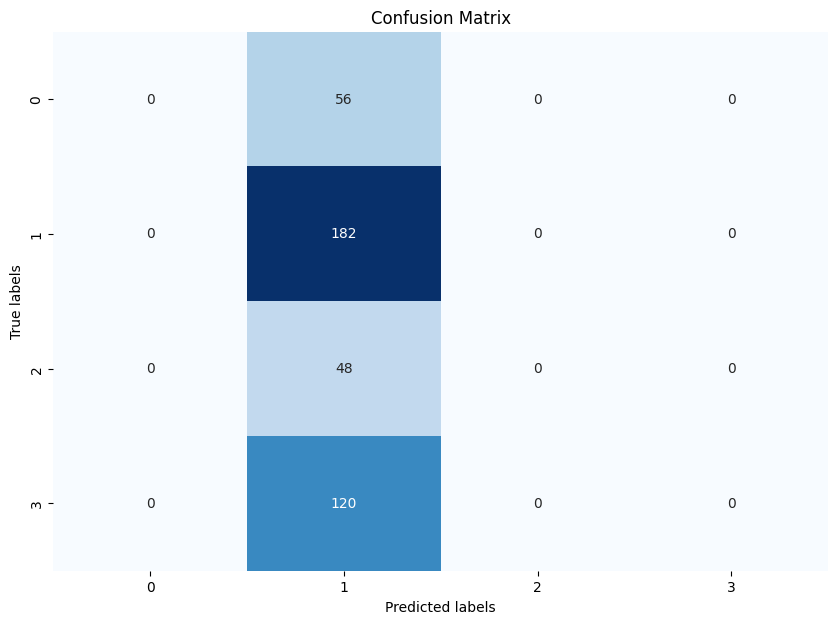

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have `y_test` and `predicted_labels` from your model's predictions
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)  # 'g' formatter prevents scientific notation
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()